# DataLoaderの実装

In [1]:
# dataset関数の実装

import numpy as np
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

class Dataset(Dataset):
    def __init__(self, text_paths, mel_paths):
        self.text_paths = text_paths
        self.mel_paths = mel_paths
        
    def __getitem__(self, index):
        return np.load(self.text_paths[index]), np.load(self.mel_paths[index])

    def __len__(self):
        return len(self.text_paths)

In [2]:
# collate_fn関数の実装

def pad_1d(x, max_len, constant_values=0):
    """
    1次元のテンソルをパディングする関数

    PARAMS
    -------
    x: パディングするテンソル
    max_len: パディングする長さ
    constant_values: パディングの値

    RETURNS
    -------
    x: パディング済みのテンソル
    """
    x = np.pad(
        x,
        (0, max_len - len(x)),
        mode = "constant",
        constant_values=constant_values,
    )
    return x

def pad_2d(x, max_len, constant_values=0):
    """
    2次元のテンソルをパディングする関数

    PARAMS
    -------
    x: パディングするテンソル
    max_len: パディングする長さ
    constant_values: パディングの値

    RETURNS
    -------
    x: パディング済みのテンソル
    """
    x = np.pad(
        x,
        [(0, max_len - len(x)), (0, 0)],
        mode="constant",
        constant_values=constant_values,
    )
    return x

def collate_fn(batch):
    """
    PARAMS
    -------
    batch: タプルのリスト(text, mel)

    RETURNS
    -------

    MEMO
    -------
    torch.from.numpyでnumpyのArrayからtorchのTensorに変換

    """
    xs = [x[0] for x in batch]  # text list
    ys = [x[1] for x in batch]  # mel list
    in_lens = [len(x) for x in xs]  # text_len list
    out_lens = [len(y) for y in ys]  # mel_len list
    in_max_len = max(in_lens)
    out_max_len = max(out_lens)
    x_batch = torch.stack([torch.from_numpy(pad_1d(x, in_max_len)) for x in xs])
    y_batch = torch.stack([torch.from_numpy(pad_2d(y, out_max_len)) for y in ys])
    in_lens = torch.tensor(in_lens, dtype=torch.long)
    out_lens = torch.tensor(out_lens, dtype=torch.long)
    stop_flags = torch.zeros(y_batch.shape[0], y_batch.shape[1])
    for idx, out_len in enumerate(out_lens):
        stop_flags[idx, out_len-1 :] = 1.0
    return x_batch, in_lens, y_batch, out_lens, stop_flags

In [3]:
import glob
import torch
from torch.utils.data import DataLoader

TEXT_DIR = "F:/ROHAN4600マルチモーダルデータベース/z2_txt/*"
MEL_DIR = "F:/ROHAN4600マルチモーダルデータベース/z2_mel/*" # normalized_db_data

textlist = sorted(glob.glob(TEXT_DIR))
mellist = sorted(glob.glob(MEL_DIR))
#print(mellist)

dataset = Dataset(textlist, mellist)
#batch_size = 32
#data_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

In [4]:
n_samples = len(dataset)
train_size = int(len(dataset) * 0.9)
test_size = n_samples - train_size
#print(train_size)
#print(test_size)

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#print(len(train_dataset))
#print(len(test_dataset))

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

In [4]:
batch_size = 2
train_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

In [5]:
#zuru
n_samples = len(dataset)
train_size = int(len(dataset) * 0.9)
test_size = n_samples - train_size
#print(train_size)
#print(test_size)

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#print(len(train_dataset))
#print(len(test_dataset))

batch_size = 16
train_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

In [5]:
print(len(train_dataset))
print(len(test_dataset))
print(len(train_loader))
print(len(test_loader))

NameError: name 'train_dataset' is not defined

In [6]:
text, text_len, mel, mel_len, stop_flags = next(iter(train_loader))
print(tuple(text.shape))
print(tuple(mel.shape))
print(text_len)
print(mel_len)
print(text.dtype)
print(mel.dtype)
print(text_len.dtype)
print(mel_len.dtype)
print(tuple(stop_flags.shape))

(2, 74)
(2, 649, 80)
tensor([74, 59])
tensor([649, 484])
torch.int32
torch.float32
torch.int64
torch.int64
(2, 649)


# 学習ループの実装

In [126]:
from Tacotron2 import Tacotron2

MODEL_DIR = "F:/model/D4/nomal_modelz5"
net = Tacotron2()
net.load_state_dict(torch.load(MODEL_DIR))
net.cuda()

Tacotron2(
  (encoder): Encoder(
    (embed): Embedding(66, 512, padding_idx=0)
    (convolutions): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
      (4): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.5, inplace=False)
      (8): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): Dropout(p=0.5, inplace=False)
    )
    (blstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )


In [127]:
def get_mask_from_lengths(lengths):
    """
    MEMO
    -------
    torch.maxは与えられたテンソルの最大値を返す関数
    .item()でテンソルの要素をpython組み込み型として取得
    torch.arangeは第一引数から第二引数まで第三引数間隔のテンソルが生成される
    """
    max_len = torch.max(lengths).item()
    ids = torch.arange(0, max_len, device=lengths.device, dtype=lengths.dtype)
    mask = (ids < lengths.unsqueeze(1)).byte()
    mask = torch.le(mask, 0)
    return mask

In [128]:
mask = ~get_mask_from_lengths(mel_len)
print(mask.shape)

torch.Size([2, 649])


In [129]:
from torch import optim
import torch.nn as nn

# 平均二乗誤差
loss_fnc = nn.MSELoss()

stop_loss_fnc = nn.BCEWithLogitsLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters(), lr=0.0001)

lr_scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=100)

# 損失のログ
record_loss_train = []
record_loss_test = []

# エポック数
epoch = 200

for i in range(epoch):
    net.train()
    loss_train = 0
    for j, (text, text_len, mel, mel_len, stop_flags) in enumerate(train_loader):
        
        text_len, indices = torch.sort(text_len, dim=0, descending=True)
        text, mel, mel_len = text[indices], mel[indices], mel_len[indices]  
        text, mel, stop_flags = text.cuda(), mel.float().cuda(), stop_flags.cuda()
        
        # 順伝播
        outs, outs_fine, logits, att_ws = net(text, text_len, mel.transpose(1, 2))
        
        # ゼロパディングを除くためにマスクを適用
        mask = ~get_mask_from_lengths(mel_len).unsqueeze(-1).to(mel.device)
        mel = mel.masked_select(mask)
        outs = outs.masked_select(mask)
        outs_fine = outs_fine.masked_select(mask)
        stop_flags = stop_flags.masked_select(mask.squeeze(-1))
        logits = logits.masked_select(mask.squeeze(-1))
        
        # 損失の計算
        decoder_out_loss = loss_fnc(outs, mel)
        postnet_out_loss = loss_fnc(outs_fine, mel)
        stop_token_loss = stop_loss_fnc(logits, stop_flags)
        
        # 損失の合計
        loss = (10 * decoder_out_loss) + (10 * postnet_out_loss) + (0.01 * stop_token_loss)
        
        loss_train += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss_train /= j+1
    record_loss_train.append(loss_train)
    
    net.eval()
    loss_test = 0
    for j, (text, text_len, mel, mel_len, stop_flags) in enumerate(test_loader):
        text_len, indices = torch.sort(text_len, dim=0, descending=True)
        text, mel, mel_len = text[indices], mel[indices], mel_len[indices]  
        text, mel, stop_flags = text.cuda(), mel.float().cuda(), stop_flags.cuda()
        
        # 順伝播
        outs, outs_fine, logits, att_ws = net(text, text_len, mel.transpose(1, 2))
        
        # ゼロパディングを除くためにマスクを適用
        mask = ~get_mask_from_lengths(mel_len).unsqueeze(-1).to(mel.device)
        mel = mel.masked_select(mask)
        outs = outs.masked_select(mask)
        outs_fine = outs_fine.masked_select(mask)
        stop_flags = stop_flags.masked_select(mask.squeeze(-1))
        logits = logits.masked_select(mask.squeeze(-1))
        
        # 損失の計算
        decoder_out_loss = loss_fnc(outs, mel)
        postnet_out_loss = loss_fnc(outs_fine, mel)
        stop_token_loss = stop_loss_fnc(logits, stop_flags)
        
        # 損失の合計
        loss = (10 * decoder_out_loss) + (10 * postnet_out_loss) + (0.01 * stop_token_loss)
        
        loss_test += loss.item()
        
    loss_test /= j+1
    record_loss_test.append(loss_test)
    
    lr_scheduler.step()
    
    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)


Epoch: 0 Loss_Train: 0.035183414816856384 Loss_Test: 0.028753085061907768
Epoch: 1 Loss_Train: 0.03507835417985916 Loss_Test: 0.028294958174228668
Epoch: 2 Loss_Train: 0.03425503149628639 Loss_Test: 0.027325449511408806
Epoch: 3 Loss_Train: 0.03473268076777458 Loss_Test: 0.02453906647861004
Epoch: 4 Loss_Train: 0.03390931710600853 Loss_Test: 0.02434445172548294
Epoch: 5 Loss_Train: 0.0320313461124897 Loss_Test: 0.024208223447203636
Epoch: 6 Loss_Train: 0.031102951616048813 Loss_Test: 0.026782792061567307
Epoch: 7 Loss_Train: 0.032904792577028275 Loss_Test: 0.0237805787473917
Epoch: 8 Loss_Train: 0.03022758848965168 Loss_Test: 0.025531800463795662
Epoch: 9 Loss_Train: 0.03310960903763771 Loss_Test: 0.02336013689637184
Epoch: 10 Loss_Train: 0.031027955934405327 Loss_Test: 0.023332366719841957
Epoch: 11 Loss_Train: 0.03059038706123829 Loss_Test: 0.025254875421524048
Epoch: 12 Loss_Train: 0.030793294310569763 Loss_Test: 0.02349657006561756
Epoch: 13 Loss_Train: 0.031730543822050095 Loss_Te

Epoch: 111 Loss_Train: 0.021662050858139992 Loss_Test: 0.016813170164823532
Epoch: 112 Loss_Train: 0.022404752671718597 Loss_Test: 0.016681179404258728
Epoch: 113 Loss_Train: 0.022574005648493767 Loss_Test: 0.016000499948859215
Epoch: 114 Loss_Train: 0.0222607608884573 Loss_Test: 0.01605965383350849
Epoch: 115 Loss_Train: 0.022593706846237183 Loss_Test: 0.016185034066438675
Epoch: 116 Loss_Train: 0.021422304213047028 Loss_Test: 0.01647900976240635
Epoch: 117 Loss_Train: 0.022060660645365715 Loss_Test: 0.016280798241496086
Epoch: 118 Loss_Train: 0.022808032110333443 Loss_Test: 0.01629023440182209
Epoch: 119 Loss_Train: 0.02346830628812313 Loss_Test: 0.016098305583000183
Epoch: 120 Loss_Train: 0.022909626364707947 Loss_Test: 0.016330119222402573
Epoch: 121 Loss_Train: 0.022099796682596207 Loss_Test: 0.016215268522500992
Epoch: 122 Loss_Train: 0.022234497591853142 Loss_Test: 0.01582619734108448
Epoch: 123 Loss_Train: 0.021899323910474777 Loss_Test: 0.016047051176428795
Epoch: 124 Loss_Tra

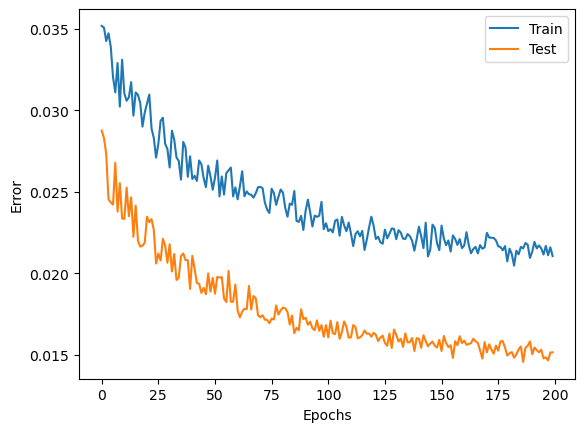

In [130]:
# 誤差の推移
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [131]:
MODEL_DIR = "F:/model/D4/nomal_modelzex"
torch.save(net.state_dict(), MODEL_DIR)

In [ ]:
print(record_loss_train.dtype)

In [13]:
LOSS_TRAIN_DIR = "F:/model/D4/nomal_model300_loss_train.npy"
LOSS_TEST_DIR = "F:/model/D4/nomal_model300_loss_test.npy"

loss_train = np.array(record_loss_train)
loss_test = np.array(record_loss_test)

np.save(LOSS_TRAIN_DIR, loss_train)
np.save(LOSS_TEST_DIR, loss_test)

# モデルの読み込み、推論

In [7]:
from Tacotron2 import Tacotron2

MODEL_DIR = "F:/model/D4/nomal_modelzex"
net2 = Tacotron2()
net2.load_state_dict(torch.load(MODEL_DIR))

<All keys matched successfully>

In [8]:
net2.cuda()

Tacotron2(
  (encoder): Encoder(
    (embed): Embedding(66, 512, padding_idx=0)
    (convolutions): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
      (4): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.5, inplace=False)
      (8): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): Dropout(p=0.5, inplace=False)
    )
    (blstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )


In [9]:
from torch.utils.data import DataLoader

data_loader = DataLoader(dataset, batch_size=2, collate_fn=collate_fn, shuffle=True)
text, text_len, mel, mel_len, stop_flags = next(iter(data_loader))
print(len(data_loader))

#plt.imshow(image[0].permute(1, 2, 0))
#print(image)

net2.eval()
text = text.cuda()

1


In [13]:
print(tuple(text.shape))
print(tuple(mel.shape))
print(text_len)
print(mel_len)
print(text.dtype)
print(mel.dtype)
print(text_len.dtype)
print(mel_len.dtype)

(2, 74)
(2, 649, 80)
tensor([74, 59])
tensor([649, 484])
torch.int32
torch.float32
torch.int64
torch.int64


In [14]:
text_len, indices = torch.sort(text_len, dim=0, descending=True)
text, mel, mel_len = text[indices], mel[indices], mel_len[indices]  
text, mel, stop_flags = text.cuda(), mel.float().cuda(), stop_flags.cuda()
        
# 順伝播
#outs, outs_fine, logits, att_ws = net2(text, text_len, mel.transpose(1, 2))

In [15]:
print(tuple(text.shape))
print(tuple(mel.shape))
print(text_len)
print(mel_len)
print(text.dtype)
print(mel.dtype)
print(text_len.dtype)
print(mel_len.dtype)
print(indices)

(2, 74)
(2, 649, 80)
tensor([74, 59])
tensor([649, 484])
torch.int32
torch.float32
torch.int64
torch.int64
tensor([0, 1])


In [16]:
outs, outs_fine, logits, att_ws = net2.inference(text, text_len)

In [17]:
import matplotlib.pyplot as plt

def plot_attention(alignment):
    """Plot attention.
    Args:
        alignment (np.ndarray): Attention.
    """
    fig, ax = plt.subplots()
    alignment = alignment.cpu().data.numpy().T
    im = ax.imshow(alignment, aspect="auto", origin="lower", interpolation="none")
    fig.colorbar(im, ax=ax)
    plt.xlabel("Decoder time step")
    plt.ylabel("Encoder time step")
    #return fig

torch.Size([524, 74])


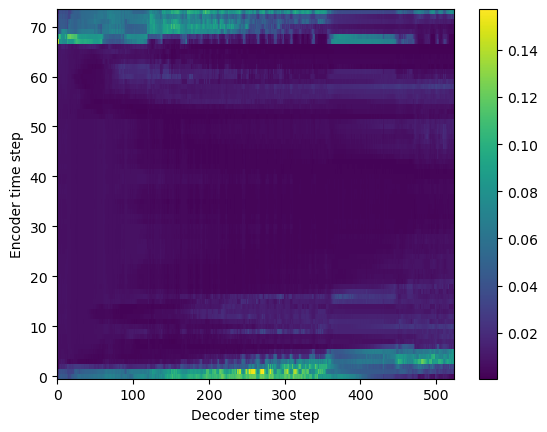

In [18]:
print(att_ws[0].shape)
plot_attention(att_ws[0])

In [19]:
outs = outs.to('cpu').detach().numpy()
print(outs.shape)
outs_fine = outs_fine.to('cpu').detach().numpy()
print(outs_fine.shape)

(2, 524, 80)
(2, 524, 80)


In [23]:
import torch
import librosa
import librosa.display

sr = 16000
n_fft = 800
hop_length = 200
win_length = 800
n_mels = 80

min_value = -80
max_value = 0

restored_mel_spectrogram = outs_fine[1] * (max_value - min_value) + min_value
power_spec = librosa.db_to_power(restored_mel_spectrogram.T)#, ref=np.max)

inverse_mel_spectrogram = librosa.feature.inverse.mel_to_stft(
    M=power_spec,
    sr=sr,
    n_fft=n_fft
)

reconstructed_waveform = librosa.griffinlim(
    inverse_mel_spectrogram,
    n_iter=100,
    hop_length=hop_length,
    win_length=win_length
)

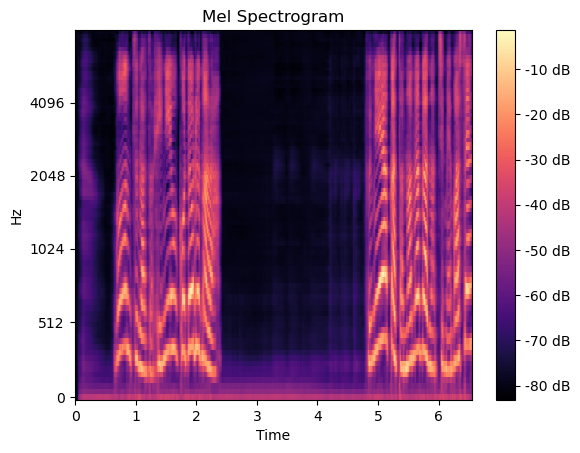

In [24]:
# メルスペクトログラムの表示
librosa.display.specshow(restored_mel_spectrogram.T, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

In [25]:
WAV_DIR = "F:/ROHAN4600マルチモーダルデータベース/wav_outs/"

import soundfile as sf

# 音声波形を保存するパスとサンプリングレートを指定します
output_path = WAV_DIR + '0138.wav'
sr = 16000  # 例として44100Hzのサンプリングレートを使用します

# 音声波形を保存します
sf.write(output_path, reconstructed_waveform, sr)